Importowanie bibliotek:

In [ ]:
import datetime
import os
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Zmienne globalne:

In [ ]:
CONFIRMED_CASES_URL = 'https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent' \
                      '.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2F' \
                      'time_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv'
GEO_URL = 'https://www.dropbox.com/s/9rpu9mbroxetg8u/country-capitals.csv?dl=1'

WEATHER_URL = 'http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key={}&q={},{}&date={}&enddate={}&format=json'
API_KEY = 'f10542d6c60048ebbb9221949202703'

Funkcja wyciągająca najniższą, najwyższą i średnią temperaturę z API World Weather Online dla stolic krajów z ostatnich 30 dni.

Dostęp do darmowej wersji API ma limit 500 zapytań, z tego powodu dane zapisywane są w pamięci podręcznej.

In [ ]:
def provide_last_30_days_of_data_for_latlngs(area_lat_lng_dict, end_date_str='2020-03-27',
                                             cache_dir='weather_data_cache'):
    start_date = datetime.datetime.strptime(end_date_str, '%Y-%m-%d') - datetime.timedelta(days=30)
    start_date_str = '{}-{:02d}-{:02d}'.format(start_date.year, start_date.month, start_date.day)

    if not os.path.exists(cache_dir):
        print('Creating cache directory: {}'.format(cache_dir))
        os.mkdir(cache_dir)

    result = []
    for i, (area_name, latlng) in enumerate(area_lat_lng_dict.items()):
        print('Providing data for: {} {} (Progress {}/{})'.format(
            area_name, latlng, i + 1, len(area_lat_lng_dict)))

        cache_filename = '{}_weather_data_{}-{}.csv'.format(
            area_name, start_date_str, end_date_str)
        cache_filepath = os.path.join(cache_dir, cache_filename)

        if os.path.exists(cache_filepath):
            print('\t- data loaded from cache: {}'.format(cache_filepath))
            result.append(pd.read_csv(cache_filepath))
        else:
            print('\t- fetching from https://www.worldweatheronline.com/ api...')

            url = WEATHER_URL.format(
                API_KEY, latlng[0], latlng[1], start_date_str, end_date_str)

            try:
                response = requests.get(url, timeout=30)
                response_json = json.loads(response.text)

                response_dict = {
                    'Country/Region': [],
                    'Date': [],
                    'Average_temperature_c': [],
                    'Max_temperature_c': [],
                    'Min_temperature_c': []
                }

                for day in response_json['data']['weather']:
                    response_dict['Date'].append(day['date'])
                    response_dict['Country/Region'].append(area_name)
                    response_dict['Average_temperature_c'].append(day['avgtempC'])
                    response_dict['Max_temperature_c'].append(day['maxtempC'])
                    response_dict['Min_temperature_c'].append(day['mintempC'])

                df_response = pd.DataFrame(response_dict)
                df_response.to_csv(cache_filepath, index=False)
                result.append(df_response)

            except Exception as e:
                if response.status_code != 200:
                    print("\t- Unable to fetch data for '{}'. Error:\n{}".format(area_name, e))

    return pd.concat(result).reset_index(drop=True)

In [ ]:
df_geo = pd.read_csv(GEO_URL)

df_country_lat_lng = df_geo[['CountryName', 'CapitalLatitude', 'CapitalLongitude']]
df_country_lat_lng.set_index('CountryName', inplace=True)

area_lat_lng_dict = {}
for row in df_country_lat_lng.itertuples():
  area_lat_lng_dict[row[0]] = row[1:]

df_country_temperature = provide_last_30_days_of_data_for_latlngs(area_lat_lng_dict)

Creating cache directory: weather_data_cache
Providing data for: Somaliland (9.55, 44.05) (Progress 1/245)
	- fetching from https://www.worldweatheronline.com/ api...
Providing data for: South Georgia and South Sandwich Islands (-54.283333, -36.5) (Progress 2/245)
	- fetching from https://www.worldweatheronline.com/ api...
Providing data for: French Southern and Antarctic Lands (-49.35, 70.216667) (Progress 3/245)
	- fetching from https://www.worldweatheronline.com/ api...
Providing data for: Palestine (31.766666666666666, 35.233333) (Progress 4/245)
	- fetching from https://www.worldweatheronline.com/ api...
Providing data for: Aland Islands (60.11666700000001, 19.9) (Progress 5/245)
	- fetching from https://www.worldweatheronline.com/ api...
Providing data for: Nauru (-0.5477, 166.920867) (Progress 6/245)
	- fetching from https://www.worldweatheronline.com/ api...
Providing data for: Saint Martin (18.0731, -63.0822) (Progress 7/245)
	- fetching from https://www.worldweatheronline.com

In [ ]:
df_confirmed_cases = pd.read_csv(CONFIRMED_CASES_URL).fillna(value=0)

col_id = df_confirmed_cases[['Province/State', 'Country/Region', 'Lat', 'Long']]
df_confirmed_cases = df_confirmed_cases.melt(id_vars=col_id, var_name='Date', value_name='CaseCount')
df_confirmed_cases['Date'] = pd.to_datetime(df_confirmed_cases['Date'])

###Wykresy:

Przygotowywanie danych do wykresu:

In [ ]:
# Ujednolicenie nazw ważniejszych państw w ramkach danych
df_confirmed_cases['Country/Region'].replace({'Korea, South':'South Korea', 'Korea, North':'North Korea', 
                                              'Czechia':'Czech Republic', 'US':'United States', 'Taiwan*':'Taiwan'}, inplace=True)

Liczba przypadków zarażenia koronawirusem na świecie wg dat


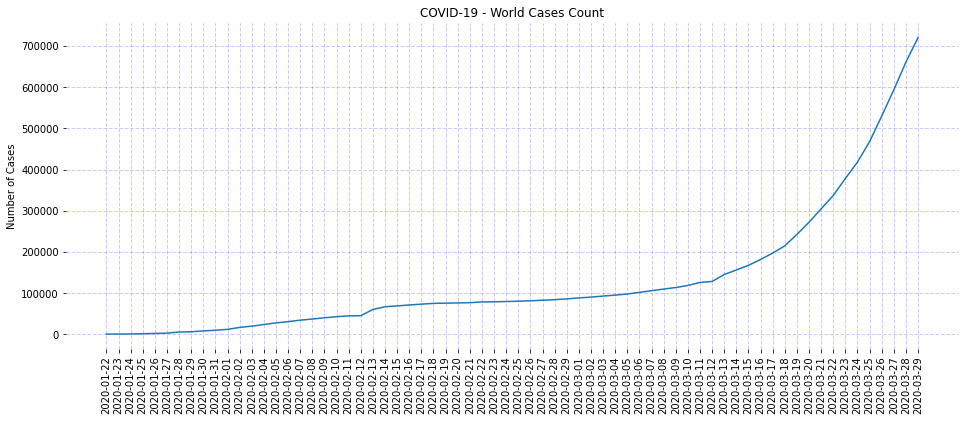

In [ ]:
world_cases_count = df_confirmed_cases.groupby(['Date'])['CaseCount'].sum()
world_cases_index, world_cases_values = world_cases_count.index.astype(str), world_cases_count.values

plt.figure(figsize=(16, 6))
plt.plot(world_cases_values)
plt.xticks(np.arange(0, len(world_cases_index)), world_cases_index, rotation=90)
plt.grid(color='blue', linestyle='--', linewidth=1, alpha=0.2)
plt.title('COVID-19 - World Cases Count')
plt.ylabel('Number of Cases')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.show()

Łączna liczba zarażonych koronawirusem w wybranych krajach

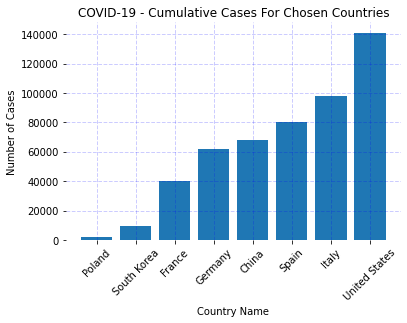

In [ ]:
cases_by_country = df_confirmed_cases.groupby(['Country/Region'])['CaseCount'].max()
chosen_countries_cases = cases_by_country.loc[['Poland', 'Italy', 'Germany', 'France', 'Spain', 'China',
                                                   'South Korea', 'United States']]
chosen_countries_cases_sorted = chosen_countries_cases.sort_values(ascending=True)

plt.bar(chosen_countries_cases_sorted.index, chosen_countries_cases_sorted.values)
plt.xticks(np.arange(0, len(chosen_countries_cases_sorted.index)), chosen_countries_cases_sorted.index, rotation=45)
plt.grid(color='blue', linestyle='--', linewidth=1, alpha=0.2)
plt.title('COVID-19 - Cumulative Cases For Chosen Countries')
plt.ylabel('Number of Cases')
plt.xlabel('Country Name')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.show()

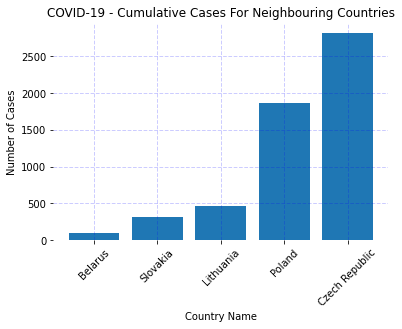

In [ ]:
cases_by_country = df_confirmed_cases.groupby(['Country/Region'])['CaseCount'].max()
chosen_countries_cases = cases_by_country.loc[['Poland', 'Czech Republic', 'Belarus',
                                                   'Lithuania', 'Slovakia']]
chosen_countries_cases_sorted = chosen_countries_cases.sort_values(ascending=True)

plt.bar(chosen_countries_cases_sorted.index, chosen_countries_cases_sorted.values)
plt.xticks(np.arange(0, len(chosen_countries_cases_sorted.index)), chosen_countries_cases_sorted.index, rotation=45)
plt.grid(color='blue', linestyle='--', linewidth=1, alpha=0.2)
plt.title('COVID-19 - Cumulative Cases For Neighbouring Countries')
plt.ylabel('Number of Cases')
plt.xlabel('Country Name')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.show()

Tempo wzrostu przypadków zarażeń koronawirusem dla wybranego kraju 


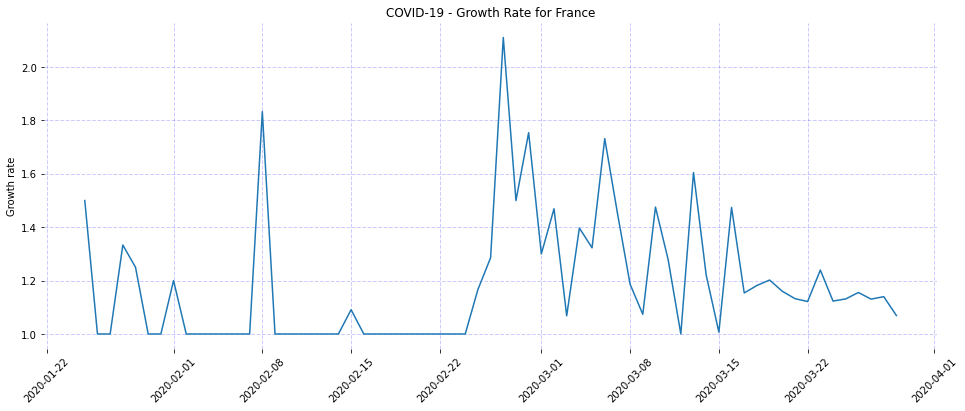

In [ ]:
def plot_growth_rate_for_a_country(country_name):
  if country_name == 'China':
    mask = df_confirmed_cases['Country/Region'] == f'{country_name}'
    cases = df_confirmed_cases.loc[mask][['Date', 'CaseCount']]
    cases = cases.reset_index(drop=True) 
    cases = cases.groupby(['Date'])['CaseCount'].sum()
    cases = pd.DataFrame(data={'Date':cases.index, 'CaseCount':cases.values})
  else:
    mask = (df_confirmed_cases['Country/Region'] == f'{country_name}') \
      & (df_confirmed_cases['Province/State'] == 0)
    cases = df_confirmed_cases.loc[mask][['Date', 'CaseCount']]
    cases = cases.reset_index(drop=True)

  index_names = cases[cases['CaseCount'] == 0].index
  cases.drop(index_names, inplace=True)
  cases.sort_values(by='Date', ascending=True, inplace=True)

  cases = pd.DataFrame(cases).reset_index(drop=True)

  cases_list = cases['CaseCount'].values

  values = []
  for i in range(len(cases_list)-1):
    today = cases_list[i]
    tomorrow = cases_list[i+1]
    growth_rate = tomorrow / today
    values.append(growth_rate)

  plt.figure(figsize=(16, 6))
  plt.plot(cases['Date'][1:], values)
  plt.grid(color='blue', linestyle='--', linewidth=1, alpha=0.2)
  plt.xticks(rotation=45)
  plt.title(f'COVID-19 - Growth Rate for {country_name}')
  plt.ylabel("Growth rate")
  plt.gca().spines['top'].set_visible(False)
  plt.gca().spines['right'].set_visible(False)
  plt.gca().spines['bottom'].set_visible(False)
  plt.gca().spines['left'].set_visible(False)
  plt.show()

plot_growth_rate_for_a_country('France')

Wykres zależności średniej temperatury od liczby przypadków zarażenia koronawirusem na przełomie ostatniego miesiąca

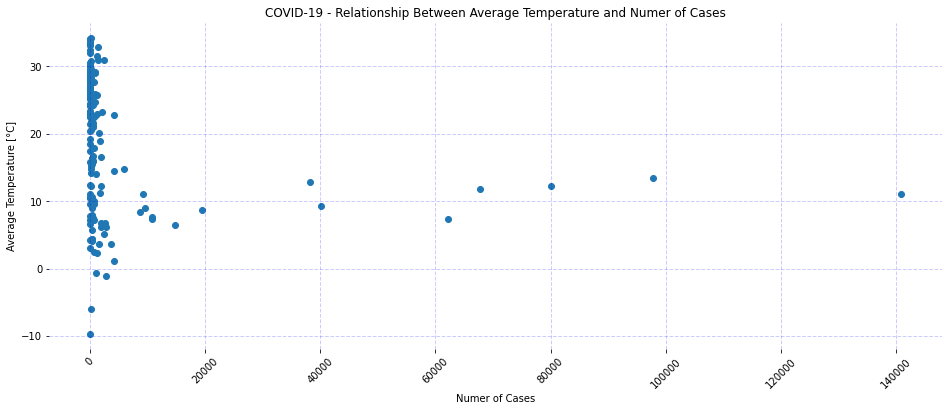

In [ ]:
df_country_temperature = df_country_temperature.astype({'Average_temperature_c': int})
temp = df_country_temperature.groupby(['Country/Region'])['Average_temperature_c'].mean()

cases_by_country = df_confirmed_cases.groupby(['Country/Region'])['CaseCount'].max()

df_temp = pd.DataFrame({'Country/Region':temp.index, 'Average_temp':temp.values})
df_cases = pd.DataFrame({'Country/Region':cases_by_country.index, 'CaseCount':cases_by_country.values})

df_merged = pd.merge(df_temp, df_cases, on=['Country/Region'])

plt.figure(figsize=(16, 6))
plt.scatter(df_merged['CaseCount'], df_merged['Average_temp'])
plt.grid(color='blue', linestyle='--', linewidth=1, alpha=0.2)
plt.xticks(rotation=45)
plt.title('COVID-19 - Relationship Between Average Temperature and Numer of Cases')
plt.xlabel('Numer of Cases')
plt.ylabel('Average Temperature [°C]')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.show()